# LSTM parser for the French Treebank

This notebook trains a parser for the French Treebank. The parser is inspired by the one presented in Tsuruoka e.a. (2015), though it uses LSTM instead of conditional random fields. Like Tsuruoka e.a. (2015), the parser operates by a type of iterative chunking, continuing until it finds an analysis of the entire sentence.


##### Load library packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pickle


from keras.models import Model, load_model
from keras.layers import Bidirectional, Dense, Input, Dropout, LSTM, Activation, TimeDistributed, BatchNormalization, concatenate, Concatenate
from keras.layers.embeddings import Embedding
from keras.constraints import max_norm
from keras import regularizers
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.initializers import glorot_uniform
from keras import backend as K
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors

from grail_data_utils import *

%matplotlib inline

np.random.seed(1)

Using TensorFlow backend.


### Read the parser actions file

The parser actions file contains triples of the form `Prosody|Formula|ParserAction`, where `Prosody` is either a word or a binary tree of words, `Formula` is formula from the TLGbank (simplified), and `ParserAction` gives the correct chunks for the current sequence, with `O` meaning a formula is outside of all chuncks.

In [3]:
def read_parsedata(file):
    with open(file, 'r') as f:
        vocabulary = set()
        vnorm = set()
        actionset = set()
        superset = set()
        sentno = 0
        maxlen = 0
        allpros = []
        allforms = []
        allactions = []
        for line in f:
            line = line.strip().split()
            length = len(line)
            sentforms = []
            sentpros = []
            sentactions = []
            if (length > maxlen):
                maxlen = length
            for l in range(length):
                item = line[l].split('|')
                pros = item[0]
                form = item[1]
                action = item[2]
                if not(pros.startswith("p(")):
                    nword = normalize_word(pros)
                    vocabulary.add(pros)
                    vnorm.add(nword)
                pros = pros.replace("p(0,", "")
                pros = pros.replace("p(1,", "")
                pros = pros.replace(")", "")
                pros = pros.split(",")
                superset.add(form)
                actionset.add(action)
                sentforms.append(form)
                sentpros.append(pros)
                sentactions.append(action)
            allpros.append(sentpros)
            allforms.append(sentforms)
            allactions.append(sentactions)
    X = np.asarray(allpros)
    Y = np.asarray(allforms)
    Z = np.asarray(allactions)
    return X, Y, Z, vocabulary, vnorm, superset, actionset, maxlen

In [4]:
# sentences with verified parses
# number of sentences, train: 9449, test: 3150, dev: 3150
pros, forms, actions, vocabulary, vnorm, superset, actionset, maxLen = read_parsedata('parse_all.txt')

In [5]:

print("Longest sentence   : ", maxLen)
print("Number of actions : ", len(actionset), actionset)
print("Number of supertags: ", len(superset), superset)


Longest sentence   :  140
Number of actions :  57 {'prod_e1', 'a_dit1', 'prod_dr2', 'prod_c2', 'prod_c1', 'ef_start1', 'O', 'e_end_r_lnr2', 'a_dit2', 'dit_np1', 'dl2', 'gap_c1', 'ef_start_iv1', 'c_l_lnr2', 'a_dit_se1', 'e_end1', 'dr1', 'prod_i2', 'se_dit1', 'c_r_lnr3', 'wpop_vp1', 'wpop_vpi1', 'c_l_lnr3', 'c_r_lnr1', 'wr2', 'let2', 'e_start_l1', 'prod_i1', 'e_end_r_lnr1', 'dl1', 'prod_w1', 'e_end_l_lnr1', 'se_dit2', 'prod_i3', 'e_endd1', 'c_r_lnr2', 'e_start1', 'prod_dr1', 'wr_a2', 'e_endd2', 'gap_i1', 'dit_np2', 'dr2', 'prod_wl1', 'wpop_vpi2', 'gap_e1', 'let1', 'a_dit_se2', 'wr1', 'gap_i2', 'e_end_l1', 'c_l_lnr1', 'e_end2', 'e_end_l_lnr2', 'wr_a1', 'e_end_l2', 'wpop1'}
Number of supertags:  509 {'dr(0,dl(0,pp,pp),pp)', 'dr(0,pp,np)', 'dl(0,dr(0,np,dia(0,box(0,pp))),dr(0,np,pp))', 'dr(0,dr(0,s,s),s)', 'dl(0,dr(0,dl(0,n,n),pp),dr(0,dl(0,n,n),pp))', 'dr(0,dr(0,s,dl(0,np,s)),cl_r)', 'dr(0,dl(0,dr(0,pp,np),np),dl(0,np,s))', 'dr(0,dl(0,np,dl(1,s,s)),dl(0,np,dl(1,s,s)))', 'dl(0,pp,np)', 'dr(

## Create auxiliary mappings

Load vector embeddings for the vocabulary. Create mappings from words, formulas and actions integers and back.

In [6]:
wv = KeyedVectors.load_word2vec_format('../wang2vec/frwiki_cwindow50_10.bin', binary=True)
veclength = 50

In [7]:
def remove_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text

Create vector mapping for all words in the vocabulary, using a zero vector for unknown words. Words are normalized before lookup (removing capitalization, etc.)

In [8]:
word_to_vec_map = {}
unknowns = set()
invoc = 0

for w in vocabulary:
    wn = normalize_word(w)
    wr = remove_prefix(wn, "-t-")
    wr = remove_prefix(wr, "-")
    try:
        vec = wv[wr]
        invoc = invoc + 1
    except:
        unknowns.add(w)
        vec = np.zeros(veclength)
    word_to_vec_map[w] = vec

print('Unknowns: ', len(unknowns))
print('In vocabulary: ', invoc)

Unknowns:  2720
In vocabulary:  11870


Compute a vector meaning for a complex prosodic term by taking the average for all words having an embedding. Other solutions, such as simple addition, are possible. An alternative would be to keep track only of the head word in each prosodic term (this will greatly reduce the embedding size and may work well)

In [9]:
def pros_to_vec(pros):
    vec = np.zeros(veclength)
    numw = 0
    for w in pros:
        wn = normalize_word(w)
        try:
            wvec = wv[wn]
            vec = vec + wvec
            numw = numw + 1
        except:
            pass
    if numw == 0:
        numw = 1
    return vec/numw    

Looks at some examples

In [10]:
print(pros[113])
print(len(pros[113]))
print(forms[113])
print(actions[113])
print(len(actions[113]))

[['Il'], ['y', 'a', 'quelques', 'jours'], ['', '', 'une', 'soixantaine', 'de', 'rebelles', 'présumés'], ['', '', 'dont', 'certains', 'étaient', 'armés'], ['', '', 'ont'], ['été', 'transférés', 'à', 'Abidjan'], ['.']]
7
['np', 'dl(0,np,dr(0,s,s))', 'np', 'dl(0,np,np)', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dl(0,np,s)', 'dl(0,s,txt)']
['dl1', 'dl2', 'dl1', 'dl2', 'dr1', 'dr2', 'O']
7


In [11]:
print(pros_to_vec(pros[113][0]))
print(pros[113][0])
print(wv['il'])

[ 0.06135423 -0.13131003 -0.18451238 -0.25952235 -0.20443681  0.28091779
  0.12621945  0.15473232  0.09866685  0.02807902 -0.31461665 -0.08482077
 -0.05280184 -0.12457576 -0.39251816  0.03320421 -0.08924808 -0.59473646
 -0.16613822 -0.20295529  0.06712979  0.16169645 -0.13465753 -0.02375351
 -0.30984667  0.02895044 -0.03812085 -0.15557894 -0.42134857  0.2752746
 -0.63396919 -0.11106327  0.27074042  0.21478277 -0.09659664  0.44096583
 -0.02110181 -0.10309666  0.22942159 -0.05130152  0.44929028  0.04754487
  0.18998609 -0.02927026  0.43349707  0.20478503  0.25512281 -0.22025017
 -0.22031641  0.02538358]
['Il']
[ 0.06135423 -0.13131003 -0.18451238 -0.25952235 -0.20443681  0.28091779
  0.12621945  0.15473232  0.09866685  0.02807902 -0.31461665 -0.08482077
 -0.05280184 -0.12457576 -0.39251816  0.03320421 -0.08924808 -0.59473646
 -0.16613822 -0.20295529  0.06712979  0.16169645 -0.13465753 -0.02375351
 -0.30984667  0.02895044 -0.03812085 -0.15557894 -0.42134857  0.2752746
 -0.63396919 -0.1110

Create the mappings to and from integers

In [12]:
word_to_index, index_to_word = indexify(vocabulary)
form_to_index, index_to_form = indexify(superset)
action_to_index, index_to_action = indexify(actionset)

## Create model inputs


In [14]:
numActions = len(index_to_action) + 1
numSuperClasses = len(index_to_form) + 1

Y = lists_to_indices(actions, action_to_index, maxLen)
X = lists_to_indices(forms, form_to_index, maxLen)

In [15]:
print(len(vocabulary))

14590


Keep 20% of the sentences as test data

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Convert integer outputs to one-hot representations

In [17]:
Y_train_oh = to_categorical(Y_train, numActions)

## Define the model

As a baseline, use the simplest possible model with access only to the formulas but no information about the words.

In [18]:
sentence_indices = Input(shape = (maxLen,), dtype = 'int32')

In [19]:
emb = Embedding(numSuperClasses,64,trainable=True,mask_zero=True)(sentence_indices)

In [20]:
LSTM1 = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(emb)
LSTM2 = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(LSTM1)

In [21]:
Act =  TimeDistributed(Dense(numActions,kernel_constraint=max_norm(5.),activation='softmax'))(LSTM2)

Define the same model using a function 

In [22]:
def parse_model(input_shape, num_super, num_actions):
    sentence_indices = Input(shape = input_shape, dtype = 'int32')
    emb = Embedding(numSuperClasses,64,trainable=True,mask_zero=True)(sentence_indices)
    LSTM1 = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(emb)
    LSTM2 = Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))(LSTM1)
    Act =  TimeDistributed(Dense(numActions,kernel_constraint=max_norm(5.),activation='softmax'))(LSTM2)
    model = Model(inputs=sentence_indices,outputs=Act)
    
    return model

In [23]:
model = parse_model((maxLen,), numSuperClasses, numActions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 140, 64)           32640     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 140, 256)          197632    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 140, 256)          394240    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 140, 58)           14906     
Total params: 639,418
Trainable params: 639,418
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(X_train, Y_train_oh, epochs=10, batch_size=32,validation_split=0.25)

Train on 109235 samples, validate on 36412 samples
Epoch 1/10
109235/109235 [==============================] - 7413s 68ms/step - loss: 0.2332 - acc: 0.9327 - val_loss: 0.0536 - val_acc: 0.9816
Epoch 2/10
109235/109235 [==============================] - 4063s 37ms/step - loss: 0.0492 - acc: 0.9820 - val_loss: 0.0386 - val_acc: 0.9858
Epoch 3/10
109235/109235 [==============================] - 5903s 54ms/step - loss: 0.0396 - acc: 0.9848 - val_loss: 0.0349 - val_acc: 0.9865
Epoch 4/10
109235/109235 [==============================] - 5956s 55ms/step - loss: 0.0357 - acc: 0.9858 - val_loss: 0.0337 - val_acc: 0.9867
Epoch 5/10
109235/109235 [==============================] - 5943s 54ms/step - loss: 0.0334 - acc: 0.9866 - val_loss: 0.0331 - val_acc: 0.9873
Epoch 6/10
109235/109235 [==============================] - 5919s 54ms/step - loss: 0.0316 - acc: 0.9872 - val_loss: 0.0318 - val_acc: 0.9876
Epoch 7/10
109235/109235 [==============================] - 5315s 49ms/step - loss: 0.0307 - acc:

#### Plot training versus validation loss and accuracy

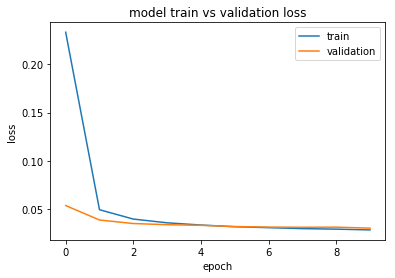

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

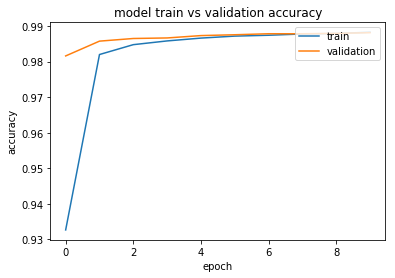

In [28]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Save everything

In [29]:
model.save('parse.h5')

In [30]:
import pickle

def save_obj(obj, name):
    with open(name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [31]:
save_obj(word_to_index, 'word_to_index')
save_obj(index_to_word, 'index_to_word')
save_obj(form_to_index, 'form_to_index')
save_obj(index_to_form, 'index_to_form')
save_obj(action_to_index, 'action_to_index')
save_obj(index_to_action, 'index_to_action')


In [33]:
X_word, pos1, pos2, X_test, v, w, ps1, ps2, sset, ml = read_maxentdata('ab2.txt')

In [41]:
def simple_formula(formula, form_to_index):
    oldformula = formula
    formula = formula.replace('_ppart', '')
    formula = formula.replace('_inf', '')
    formula = formula.replace('_pass', '')
    formula = formula.replace('_de', '')
    formula = formula.replace('_par', '')
    formula = formula.replace('_a', '')
    formula = formula.replace('_q', '')
    if not formula == oldformula:
        form_to_index[oldformula] = form_to_index[formula]
    return formula, form_to_index

In [42]:
fset = form_to_index.keys()
for f in sset:
    if f not in fset:
        sf, form_to_index = simple_formula(f, form_to_index)

KeyError: 'dr(0,dr(0,dr(0,s,s),dl(0,np,s)),np)'

In [36]:
X_test_indices = lists_to_indices(X_test, form_to_index, maxLen)

Unknown:  dr(0,dl(0,n,n),pp_a)
Unknown:  dr(0,pp_a,np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),np)
Unknown:  dr(0,pp_a,np)
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s)),pp_a)
Unknown:  dr(0,pp_a,n)
Unknown:  dr(0,np,pp_de)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_pass))
Unknown:  dl(0,np,s_pass)
Unknown:  dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s),dr(0,dl(0,np,s),dia(1,box(1,pp_de))))
Unknown:  dr(0,dr(0,dl(0,np,s_inf),pp_de),np)
Unknown:  dr(0,dl(0,np,s),s_q)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,pp_de,pp_a),np)
Unknown:  dr(0,dl(0,np,np),s_q)
Unknown:  dr(0,s_q,np)
Unknown:  dr(0,dl(0,np,s),pp_de)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s_inf)),pp_de)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0

Unknown:  dr(0,dl(0,np,s),dl(0,np,s_pass))
Unknown:  dr(0,dl(0,np,s_pass),pp_a)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dl(0,n,n),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dr(0,dl(0,np,s),dl(0,np,s_inf)),dl(0,n,n))
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),s_q)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s)),pp_de)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(1,s,s),s_q)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s)),dr(0,dl(0,cl_r,dl(0,np,s)),dia(1,box(1,pp_de))))
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s)),pp_de)
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s),dr(0,dl(0,np,s),dia(1,box(1,pp_de))))
Unknown:  dr(0,dr(0,dl(0,np,s_inf),s_q),pp_de)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,cl_r,dl(0,np,s_inf)),pp_a)
Unknown:  dr(0,pp_a,np)
Unknown:  dr(0,s_whq,dr(0,s,dia(1,box(1,np))))
Unknown:  dr(0,dr(0,s,np),

Unknown:  dr(0,dl(0,np,s),dl(0,np,s_pass))
Unknown:  dl(0,np,s_pass)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),s_q)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dr(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s_ppres))
Unknown:  dr(0,dl(0,np,s_ppres),np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),np)
Unknown:  dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s_ppres))
Unknown:  dr(0,dl(0,np,s_ppres),np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),np)
Unknown:  dr(0,n,pp_de)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,n,n),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_pass))
Unknown:  dl(0,np,s_pass)
Unknown:  dr(0,pp_a,n)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0,n,n),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dr(0,dl(0,np,s_inf),dl(0,np,s_inf)),np)
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_

Unknown:  dr(0,dl(1,s,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0,np,s),s_q)
Unknown:  dr(0,s_q,s)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),dl(0,np,s_pass))
Unknown:  dr(0,dl(0,np,s_pass),pp_par)
Unknown:  dr(0,dl(0,np,s_pass),pp_par)
Unknown:  dr(0,pp_par,np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),dl(0,np,s_pass))
Unknown:  dr(0,dl(0,np,s_pass),pp_par)
Unknown:  dr(0,pp_par,np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_ppart))
Unknown:  dr(0,dl(0,np,s_ppart),pp)
Unknown:  dr(0,pp_de,np)
Unknown:  dr(0,dl(0,n,n),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(1,s,s),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),np)
Unknown:  dr(0,dl(0,np,s),dl(0,np,s_pass))
Unknown:  dr(0,dl(0,np,s_pass),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s_inf),dl(0,np,s_inf))
Unknown:  dr(0,dl(0,np,s),dr(0,dl(0,np,s),dia(1,bo

In [52]:
test = X[0:3]

In [53]:
pred = model.predict(test)

In [61]:
print(len(test[0]))

140


In [70]:
allpredictions = []
for i in range(len(test)):
    predictions = []
    for j in range(len(forms[i])):
        num = np.argmax(pred[i][j])
        print(forms[i][j] + '|' + index_to_action[num])
        predictions.append(index_to_action[num])
    allpredictions.append(predictions)
    print('===')

np|O
dr(0,dl(0,np,np),pp)|O
dr(0,pp,np)|dr1
np|dr2
dr(0,dl(0,np,np),dl(0,n,n))|O
dr(0,dl(0,n,n),dl(0,n,n))|dr1
dl(0,n,n)|dr2
let|let1
dr(0,dl(0,np,s),dl(0,np,s))|let2
dr(0,dl(0,np,s),dl(0,np,s))|O
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),pp)|O
dr(0,pp,np)|O
dr(0,np,n)|O
dr(0,n,n)|dr1
n|dr2
dr(0,dl(0,n,n),np)|O
dr(0,np,n)|dr1
n|dr2
let|let1
dr(0,dl(1,s,s),n)|let2
dr(0,n,n)|dr1
n|dr2
let|let1
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))|let2
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),pp)|O
dr(0,dl(1,s,s),n)|dr1
n|dr2
let|let1
dr(0,pp,np)|let2
dr(0,np,n)|dr1
n|dr2
dl(0,s,txt)|O
===
np|O
dr(0,dl(0,np,np),pp)|dr1
pp|dr2
dr(0,dl(0,np,np),dl(0,n,n))|dr1
dl(0,n,n)|dr2
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
cl_r|O
dr(0,dl(0,cl_r,dl(0,np,s)),pp)|O
dr(0,pp,np)|O
dr(0,np,n)|O
n|O
dr(0,dl(0,n,n),np)|dr1
np|dr2
dr(0,dl(1,s,s),n)|dr1
n|dr2
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0,np,s),dl(0,np,s))|O
dr(0,dl(0

In [116]:
def reduce_sequence(forms, actions):
    for i in range(len(forms)):
        if actions[i] == 'dr1' and actions[i+1] == 'dr2':
            arg = forms[i+1]
            fun = forms[i]
            print('=dr=')
            print(fun)
            print(arg)
            begin = fun.rfind(arg, 5, len(fun)-1)
            if fun[0:3] == "dr(" and fun[begin:len(fun)-1] == arg:
                result = fun[5:begin-1]
                print(result)
                print('===')
        elif actions[i] == 'dl1' and actions[i+1] == 'dl2':
            arg = forms[i]
            fun = forms[i+1]
            print('=dl=')
            print(arg)
            print(fun)
            begin = fun.find(arg, 5, len(fun)-1)
            rstart = begin+len(arg)
            if fun[0:3] == "dl(" and fun[begin:rstart] == arg:
                result = fun[rstart+1:len(fun)-1]
                print(result)
                print('===')
        elif actions[i] == 'let1' and actions[i+1] == 'let2':
            let1 = forms[i]
            let2 = forms[i+1]
            print('=let=')
            if let1 == "let":
                result = let2
            elif let2 == "let":
                result = let1
            print(let1)
            print(let2)
            print(result)
            print('===')
   

In [117]:
print(forms[0])
print(allpredictions[0])

['np', 'dr(0,dl(0,np,np),pp)', 'dr(0,pp,np)', 'np', 'dr(0,dl(0,np,np),dl(0,n,n))', 'dr(0,dl(0,n,n),dl(0,n,n))', 'dl(0,n,n)', 'let', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'cl_r', 'dr(0,dl(0,cl_r,dl(0,np,s)),pp)', 'dr(0,pp,np)', 'dr(0,np,n)', 'dr(0,n,n)', 'n', 'dr(0,dl(0,n,n),np)', 'dr(0,np,n)', 'n', 'let', 'dr(0,dl(1,s,s),n)', 'dr(0,n,n)', 'n', 'let', 'dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),dl(0,np,s))', 'dr(0,dl(0,np,s),pp)', 'dr(0,dl(1,s,s),n)', 'n', 'let', 'dr(0,pp,np)', 'dr(0,np,n)', 'n', 'dl(0,s,txt)']
['O', 'O', 'dr1', 'dr2', 'O', 'dr1', 'dr2', 'let1', 'let2', 'O', 'O', 'O', 'O', 'O', 'dr1', 'dr2', 'O', 'dr1', 'dr2', 'let1', 'let2', 'dr1', 'dr2', 'let1', 'let2', 'O', 'O', 'O', 'dr1', 'dr2', 'let1', 'let2', 'dr1', 'dr2', 'O']


In [120]:
reduce_sequence(forms[0], allpredictions[0])

=dr=
dr(0,pp,np)
np
pp
===
=dr=
dr(0,dl(0,n,n),dl(0,n,n))
dl(0,n,n)
dl(0,n,n)
===
=let=
let
dr(0,dl(0,np,s),dl(0,np,s))
dr(0,dl(0,np,s),dl(0,np,s))
===
=dr=
dr(0,n,n)
n
n
===
=dr=
dr(0,np,n)
n
np
===
=let=
let
dr(0,dl(1,s,s),n)
dr(0,dl(1,s,s),n)
===
=dr=
dr(0,n,n)
n
n
===
=let=
let
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))
dr(0,dl(0,dl(0,np,s),dl(0,np,s)),dl(0,np,s))
===
=dr=
dr(0,dl(1,s,s),n)
n
dl(1,s,s)
===
=let=
let
dr(0,pp,np)
dr(0,pp,np)
===
=dr=
dr(0,np,n)
n
np
===


In [89]:
arg = "n"
fun = "dr(0,n,n)"
begin = fun.find(arg, 5, len(fun)-1)
result = fun[5:begin+1]

In [90]:
print(result)

n


In [91]:
print(begin)

5
